# Import

In [23]:
import os
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
os.environ["WANDB_DISABLED"] = "true"

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

In [25]:
train_df=pd.read_excel('/kaggle/input/augmented-dataset/train.xlsx')
test_df=pd.read_excel('/kaggle/input/augmented-dataset/test.xlsx')
val_df = pd.read_excel('/kaggle/input/augmented-dataset/dev.xlsx')

In [26]:
train_df = train_df.rename(columns={'text': 'Review'})
test_df = test_df.rename(columns={'text': 'Review'})
val_df = val_df.rename(columns={'text': 'Review'})

# Making Dataset Dictionary 

In [27]:
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split



# Convert DataFrames to Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Print the DatasetDict
print(dataset_dict)


DatasetDict({
    train: Dataset({
        features: ['Review', 'label'],
        num_rows: 5400
    })
    validation: Dataset({
        features: ['Review', 'label'],
        num_rows: 1330
    })
    test: Dataset({
        features: ['Review', 'label'],
        num_rows: 2016
    })
})


In [28]:
raw_datasets=dataset_dict

# Loading BERT

In [29]:
# Load the tokenizer for the Bagla BERT model
checkpoint = "sagorsarker/Bangla-bert-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

In [30]:
max_length = 100

In [31]:
def tokenize_function(examples):
    return tokenizer(examples['Review'],max_length = 100, truncation=True)

In [32]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/5400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1330 [00:00<?, ? examples/s]

Map:   0%|          | 0/2016 [00:00<?, ? examples/s]

In [33]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [34]:
from transformers import TrainingArguments
training_args = TrainingArguments("test-trainer")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [35]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/Bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
training_args = TrainingArguments(
    output_dir='./results',
    logging_dir="./logs",
    logging_strategy="epoch",
    evaluation_strategy="epoch",  
    save_strategy="epoch",
    learning_rate=1.29e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    eval_steps=250,
    save_total_limit=2,  # Keep only 2 latest checkpoints
    load_best_model_at_end=True,  
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    optim="adamw_torch"  # Explicitly set AdamW
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [37]:
def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [38]:


from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Stop if no improvement in 3 evals
)


<ipython-input-38-97cd25e8e773>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Training

In [39]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.763400,0.663841,0.706015,0.639971,0.717567,0.612273
2,0.505200,0.679575,0.722556,0.695487,0.698737,0.702294
3,0.321100,0.782602,0.711278,0.678797,0.690260,0.669743
4,0.196200,1.006851,0.706015,0.671611,0.671335,0.674850


TrainOutput(global_step=1352, training_loss=0.4464962242623053, metrics={'train_runtime': 242.9937, 'train_samples_per_second': 1111.14, 'train_steps_per_second': 69.549, 'total_flos': 906224277862512.0, 'train_loss': 0.4464962242623053, 'epoch': 4.0})

In [40]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.6638405919075012, 'eval_accuracy': 0.706015037593985, 'eval_f1': 0.6399711210145794, 'eval_precision': 0.7175666831252862, 'eval_recall': 0.6122729175552905, 'eval_runtime': 3.3844, 'eval_samples_per_second': 392.975, 'eval_steps_per_second': 24.819, 'epoch': 4.0}


# Result

In [41]:
from sklearn.metrics import classification_report

# Make predictions on the test set
test_results = trainer.predict(tokenized_datasets['test'])

# Extract predictions and true labels
predictions = test_results.predictions.argmax(axis=-1)
true_labels = test_results.label_ids

# Generate classification report
report = classification_report(true_labels, predictions, target_names=['Non-Violence', 'Passive_Violence', 'Direct Violence'])
print(report)


                  precision    recall  f1-score   support

    Non-Violence       0.71      0.89      0.79      1096
Passive_Violence       0.75      0.48      0.58       719
 Direct Violence       0.62      0.56      0.59       201

        accuracy                           0.71      2016
       macro avg       0.69      0.64      0.65      2016
    weighted avg       0.71      0.71      0.69      2016



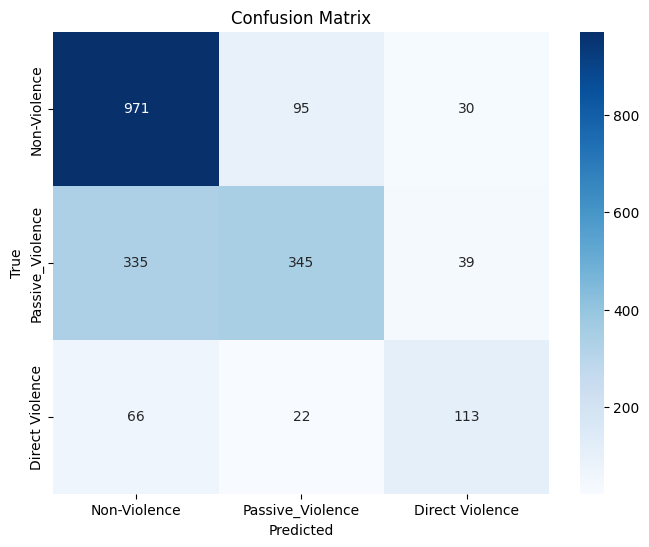

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Violence', 'Passive_Violence', 'Direct Violence'], yticklabels=['Non-Violence', 'Passive_Violence', 'Direct Violence'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [43]:
from sklearn.metrics import classification_report

# Make predictions on the test set
test_results = trainer.predict(tokenized_datasets['validation'])

# Extract predictions and true labels
predictions = test_results.predictions.argmax(axis=-1)
true_labels = test_results.label_ids

# Generate classification report
report = classification_report(true_labels, predictions, target_names=['Non-Violence', 'Passive_Violence', 'Direct Violence'])
print(report)


                  precision    recall  f1-score   support

    Non-Violence       0.72      0.85      0.78       717
Passive_Violence       0.66      0.60      0.63       417
 Direct Violence       0.77      0.38      0.51       196

        accuracy                           0.71      1330
       macro avg       0.72      0.61      0.64      1330
    weighted avg       0.71      0.71      0.69      1330



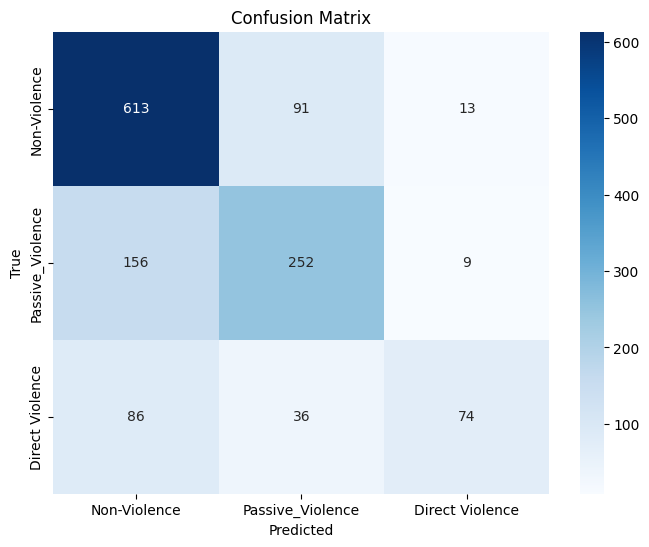

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Violence', 'Passive_Violence', 'Direct Violence'], yticklabels=['Non-Violence', 'Passive_Violence', 'Direct Violence'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()